<a href="https://colab.research.google.com/github/OFKadi/Bitirme_Projesi/blob/main/Jupyter_Notebooks/Two_Body_HO_Gauss_Cutoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import scipy.special as ss
import scipy as sp
import matplotlib.pyplot as plt
import math

from scipy import optimize
from scipy.integrate import quad, quadrature, fixed_quad

In [35]:
def phi_n(r, n):
  r2 = r*r
  return 2*np.exp(-r2/2)*ss.assoc_laguerre(r2,n,1/2) / ( np.pi**.25*np.sqrt(ss.assoc_laguerre(0,n,1/2)) )

In [36]:
def Vint(r, r0, q):
  return -q**2*np.exp((-r**2)/(r0**2))

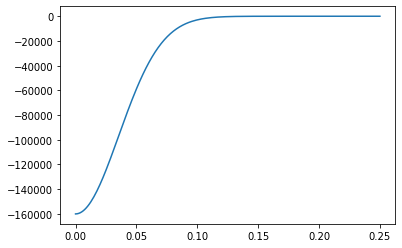

In [37]:
xx = np.linspace(0, 5*0.05, 200)
yy = Vint(xx, 0.05, 400)
plt.plot(xx, yy)

In [38]:
def int_func(r, n, m, r0, q):
  return phi_n(r, n)*phi_n(r, m)*Vint(r, r0, q)*r**2

In [39]:
def get_Hrel(nmax, r0, q):
  Hrel = np.zeros([nmax,nmax])

  for n in range(nmax):
      
      Hrel[n,n] = 2*n+1.5 + fixed_quad(int_func, 0, 10*r0, args=(n, n, r0, q), n=6)[0]

  for n in range(nmax):
      for m in range(n+1,nmax):
          
          Hrel[n,m] = fixed_quad(int_func, 0, 10*r0, args=(n, m, r0, q), n=6)[0]
          Hrel[m,n] = Hrel[n,m]
  return Hrel

In [40]:
def get_as_cutoff(q0, r0, kc):
  erf = ss.erf(kc*r0/2)
  a = (-q0**2*r0**3)
  b = 8*2**.5*np.pi
  c = 2*np.pi**(-1)*q0**2*r0**2*erf
  return a/(b-c)

In [41]:
def busch_16(E):
  a_0 = ss.gamma(-E/2+.25)/(ss.gamma(-E/2+.75)*np.sqrt(2))
  return a_0

In [44]:
%%time
nmax_list = [100, 200, 300, 400, 500, 600, 700, 800] #np.arange(15, 400, 20)
r0 = 0.05
a_0 = 1
res = []
for nmax in nmax_list:
    kc = (nmax/2)**.5
    q = optimize.fsolve(lambda q: get_as_cutoff(q,r0, kc)-a_0, np.pi/(2*r0/1.01))[0]
    # print(get_as_cutoff(q,r0, kc)-a_0)
    # print(q)
    Hrel = get_Hrel(nmax, r0, abs(q))
    ee = np.linalg.eigvalsh(Hrel)
    res.append(ee[:12])
    print(nmax, end="-")
    
all_eigs = np.array(res)

e_b = np.zeros((1,12))
e_b[0,0] = optimize.brentq(lambda E: busch_16(E)-a_0, .5001, 2.4999)
e_b[0,1] = optimize.brentq(lambda E: busch_16(E)-a_0, 2.5001, 4.4999)
e_b[0,2] = optimize.brentq(lambda E: busch_16(E)-a_0, 4.5001, 6.4999)
e_b[0,3] = optimize.brentq(lambda E: busch_16(E)-a_0, 6.5001, 8.4999)

100-200-300-400-500-600-700-800-CPU times: user 2min 4s, sys: 1.1 s, total: 2min 5s
Wall time: 2min 4s


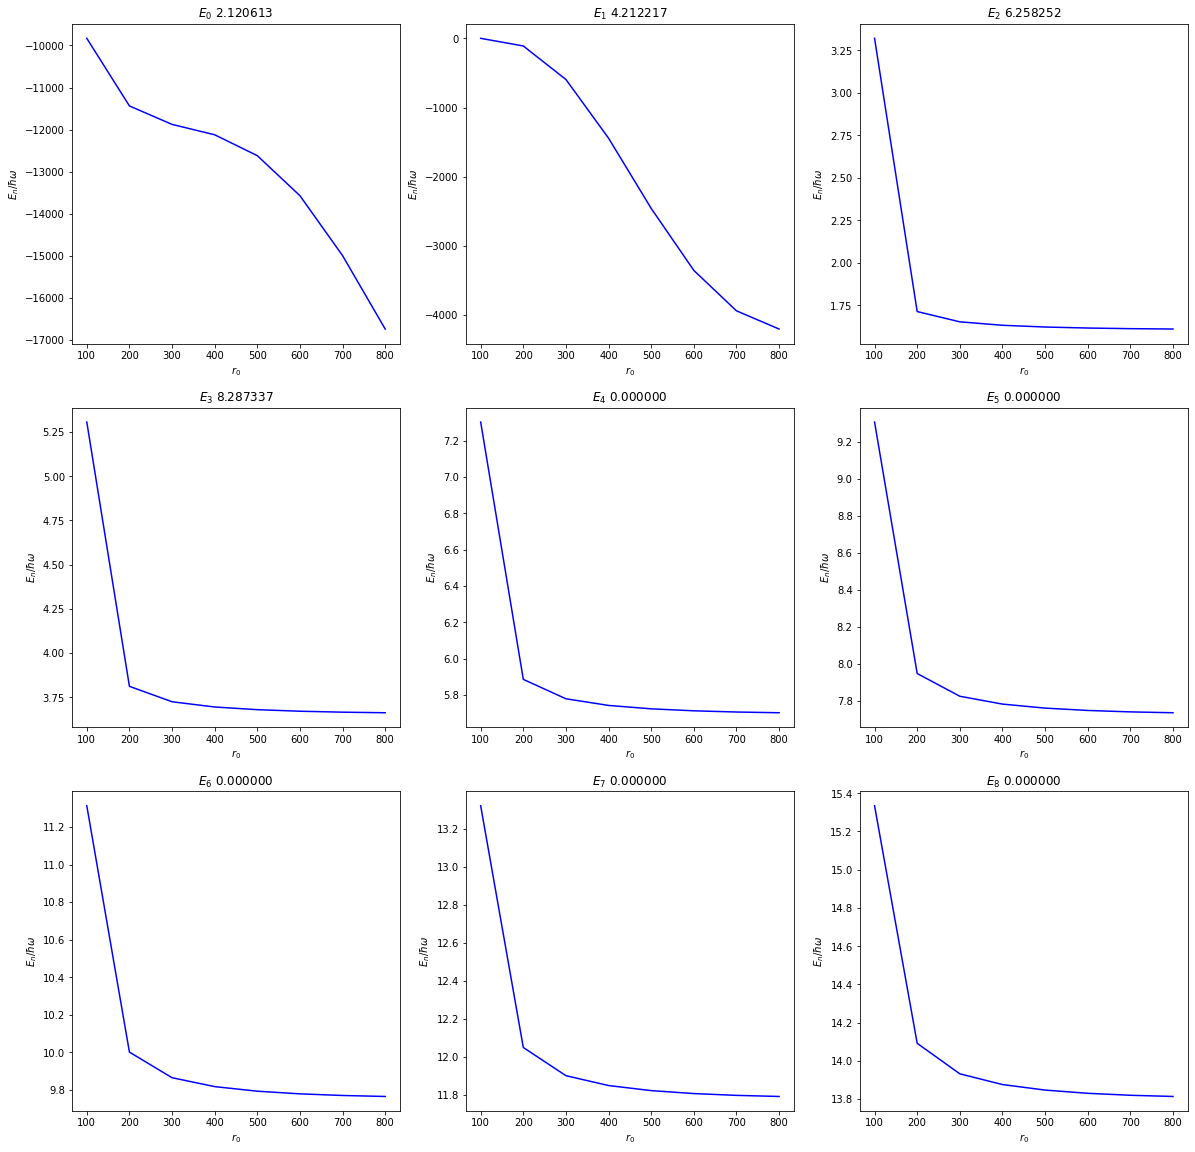

In [45]:
fig, ax = plt.subplots(3, 3, figsize=(20,20))
ax_list = ax.flatten()

for i, ax in enumerate(ax_list):
  ax.plot(nmax_list, all_eigs[:,i], 'b')
  ax.set_ylabel(r"$E_n/\hbar\omega$" )
  ax.set_xlabel(r"$r_0$")
  ax.set_title("$E_%d$ %f" %(i,e_b[0,i]))